## Dataset: отзывы о приложении (`'Ru'`)

**TODO:**

Провести сравнение RNN, LSTM, GRU на датасете отзывов (из предыдущих занятий/материалов)

In [1]:
##############
# Import libs
##############

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
from stop_words import get_stop_words
from string import punctuation
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import word_tokenize
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from nltk.probability import FreqDist
import random
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN , LSTM, GRU, Masking
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping 
from gensim.models import Word2Vec
import multiprocessing

Using TensorFlow backend.


In [2]:
###########
# Settings
###########

# Fix seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Constants
max_words = 2000
max_len = 50
epochs = 20
batch_size = 4096
vec_len = 10
N_CLASSES = 2

sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

# Load data
data = pd.read_excel('data/отзывы за лето.xls', parse_dates=[2])

# Specify fields under focus 
TARGET = 'target'
PROCESSED = 'preprocessed'

In [3]:
data

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,5,Ок,2017-06-01
20656,4,Доволен,2017-06-01
20657,1,"Песопаснасть, рут ни нужын",2017-06-01


In [4]:
"""Processing block"""

def preprocess_text(txt):
    
    """
    Строковый препроцессинг. Чистит лишнюю пунктуацию, приводит слова к номальной форме
    """
    
    txt = str(txt)
    txt = re.sub(r'( )+', " ", re.sub(r'[^\w\s]', " ", txt)).strip()
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = " ".join(txt)
    txt = re.sub("\sне", "не", txt)
    return txt

def prepare_data(df: pd.DataFrame,
                 n_classes: int,
                 processed_field: str = PROCESSED,
                 target_field: str = TARGET) -> pd.DataFrame:
    
    assert n_classes in [2,5], 'Bad Number of classes'
    
    print(f"Data preparing...", end="")
    
    """
    Предобработка данных под тип классификатора. Преобразование таргета для one-hot encoding
    Ожидает на вход n_classes: 2 | 5
    """
    
    
    df[processed_field] = df['Content'].apply(preprocess_text)
    
    if n_classes == 2:
        df = df[df['Rating'] != 3]
        df[target_field] = (df['Rating'] > 3).astype('uint8')
        
    else:
        df[target_field] = df['Rating'] - 1
    
    return df
    

def get_splits(data, seed=seed):
    
    """
    Разделение датасета на 3 сплита в пропорции (60% + 20% + 20%)
    """
    
    print(f"Preparing splits...", end="")
    
    # Split dataset on 3 folds
    train, test = train_test_split(data, test_size=0.6, shuffle=True, random_state=seed)
    valid, test = train_test_split(test, test_size=0.5, shuffle=True, random_state=seed)
    
    return train, valid, test
    

def build_model(memory_cells_type: callable,
                n_classes: int,
                max_words: int,
                train_len: int
               ):
    
    """
    Построение рекурентной модели в зависимости от типа
    
    Parameters
    ----------
    memory_cells_type: callable
        Тип ячеек памяти. Ожидает на вход tf.keras слои: SimpleRNN, LSTM, GRU ...
    
    n_classes: int
        Количество классов модели
    
    max_words: int
        Максимальное количество слов в текстовой последовательности
    
    max_len: int
        Длина вектора последовательностей
        
    """
    
    print(f"Model Building...", end="")

    model = Sequential()

    model.add(
        Embedding(input_dim=max_words,
                  input_length=train_len,
                  output_dim=30,
                  trainable=True,
                  mask_zero=True))
    model.add(Masking(mask_value=0.0))

    model.add(memory_cells_type(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    print("Done. Model Summary:")
    print(model.summary())
    
    return model

def plot_history(history):
    
    """
    Вывод фукнций потерь и точности модели  
    """
    
    fig, ax = plt.subplots(1,2, figsize=(16,4))

    ax[0].plot(history.history['loss'], label='train loss')
    ax[0].plot(history.history['val_loss'], label='validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(history.history['accuracy'], label='train accuracy')
    ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

In [5]:
data = prepare_data(df=data, n_classes=N_CLASSES)
df_train, df_val, df_test = get_splits(data)

text_corpus_train = df_train[PROCESSED].values
text_corpus_valid = df_val[PROCESSED].values
text_corpus_test = df_test[PROCESSED].values

tokenizer = Tokenizer(num_words=None, 
                      lower = False,
                      split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)
X_test = pad_sequences(sequences_test, maxlen=training_length)

y_train = df_train[TARGET].values
y_val = df_val[TARGET].values
y_test = df_test[TARGET].values

Data preparing...

C:\Users\Nickel\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preparing splits...

## RNN

In [7]:
model = build_model(memory_cells_type=SimpleRNN,
                    n_classes=N_CLASSES,
                    max_words=word_count,
                    train_len=training_length)

Model Building...Done. Model Summary:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 101, 30)           154620    
_________________________________________________________________
masking_1 (Masking)          (None, 101, 30)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                6080      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 164,925
Trainable params: 164,925
Non-trainable params: 0
__________

In [8]:
%%time

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

C:\Users\Nickel\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7109 samples, validate on 790 samples
Epoch 1/20
7109/7109 [==============================] - 1s 136us/step - loss: 0.6482 - accuracy: 0.7292 - val_loss: 0.5715 - val_accuracy: 0.8354
Epoch 2/20
7109/7109 [==============================] - 0s 33us/step - loss: 0.5587 - accuracy: 0.8177 - val_loss: 0.4897 - val_accuracy: 0.8354
Epoch 3/20
7109/7109 [==============================] - 0s 33us/step - loss: 0.4807 - accuracy: 0.8408 - val_loss: 0.4426 - val_accuracy: 0.8354
Epoch 4/20
7109/7109 [==============================] - 0s 32us/step - loss: 0.4366 - accuracy: 0.8479 - val_loss: 0.4414 - val_accuracy: 0.8354
Epoch 5/20
7109/7109 [==============================] - 0s 34us/step - loss: 0.4454 - accuracy: 0.8481 - val_loss: 0.4572 - val_accuracy: 0.8354
Wall time: 2.68 s


In [9]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

5924/5924 [==============================] - 0s 29us/step


Test score: 0.4382634056250362
Test accuracy: 0.8440243005752563


In [10]:
res = model.predict(X_test)
print(f'Test score: {round(roc_auc_score(y_test, res),3)}')

Test score: 0.866


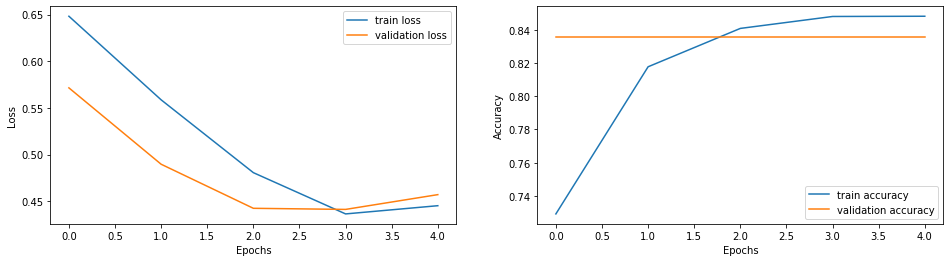

In [11]:
plot_history(history)

## LSTM

In [12]:
model = build_model(memory_cells_type=LSTM,
                    n_classes=N_CLASSES,
                    max_words=word_count,
                    train_len=training_length)

Model Building...Done. Model Summary:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 101, 30)           154620    
_________________________________________________________________
masking_2 (Masking)          (None, 101, 30)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 183,165
Trainable params: 183,165
Non-trainable params: 0
__________

In [13]:
%%time

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

C:\Users\Nickel\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7109 samples, validate on 790 samples
Epoch 1/20
7109/7109 [==============================] - 1s 153us/step - loss: 0.6915 - accuracy: 0.5625 - val_loss: 0.6771 - val_accuracy: 0.8354
Epoch 2/20
7109/7109 [==============================] - 1s 73us/step - loss: 0.6730 - accuracy: 0.8491 - val_loss: 0.6583 - val_accuracy: 0.8354
Epoch 3/20
7109/7109 [==============================] - 1s 73us/step - loss: 0.6527 - accuracy: 0.8488 - val_loss: 0.6346 - val_accuracy: 0.8354
Epoch 4/20
7109/7109 [==============================] - 1s 71us/step - loss: 0.6269 - accuracy: 0.8488 - val_loss: 0.6014 - val_accuracy: 0.8354
Epoch 5/20
7109/7109 [==============================] - 1s 70us/step - loss: 0.5888 - accuracy: 0.8488 - val_loss: 0.5498 - val_accuracy: 0.8354
Epoch 6/20
7109/7109 [==============================] - 1s 72us/step - loss: 0.5300 - accuracy: 0.8488 - val_loss: 0.4680 - val_accuracy: 0.8354
Epoch 7/20
7109/7109 [==============================] - 1s 72us/step - loss: 0.442

In [14]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

5924/5924 [==============================] - 0s 84us/step


Test score: 0.4443417434592572
Test accuracy: 0.8440243005752563


In [15]:
res = model.predict(X_test)
print(f'Test score: {round(roc_auc_score(y_test, res),3)}')

Test score: 0.886


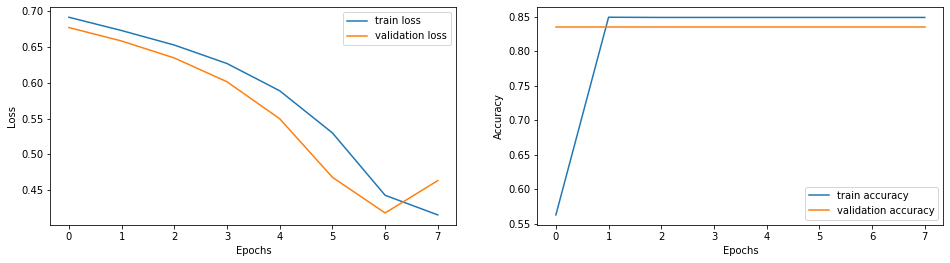

In [16]:
plot_history(history)

## GRU

In [17]:
model = build_model(memory_cells_type=GRU,
                    n_classes=N_CLASSES,
                    max_words=word_count,
                    train_len=training_length)

Model Building...Done. Model Summary:
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 101, 30)           154620    
_________________________________________________________________
masking_3 (Masking)          (None, 101, 30)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18240     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 177,085
Trainable params: 177,085
Non-trainable params: 0
__________

In [18]:
%%time

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

C:\Users\Nickel\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7109 samples, validate on 790 samples
Epoch 1/20
7109/7109 [==============================] - 1s 143us/step - loss: 0.6926 - accuracy: 0.5279 - val_loss: 0.6829 - val_accuracy: 0.8354
Epoch 2/20
7109/7109 [==============================] - 1s 73us/step - loss: 0.6802 - accuracy: 0.8434 - val_loss: 0.6720 - val_accuracy: 0.8354
Epoch 3/20
7109/7109 [==============================] - 1s 78us/step - loss: 0.6684 - accuracy: 0.8486 - val_loss: 0.6592 - val_accuracy: 0.8354
Epoch 4/20
7109/7109 [==============================] - 1s 75us/step - loss: 0.6548 - accuracy: 0.8488 - val_loss: 0.6434 - val_accuracy: 0.8354
Epoch 5/20
7109/7109 [==============================] - 1s 77us/step - loss: 0.6376 - accuracy: 0.8488 - val_loss: 0.6238 - val_accuracy: 0.8354
Epoch 6/20
7109/7109 [==============================] - 1s 74us/step - loss: 0.6160 - accuracy: 0.8488 - val_loss: 0.5995 - val_accuracy: 0.8354
Epoch 7/20
7109/7109 [==============================] - 1s 74us/step - loss: 0.589

In [19]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

5924/5924 [==============================] - 0s 60us/step


Test score: 0.38780353922122723
Test accuracy: 0.8440243005752563


In [20]:
res = model.predict(X_test)
print(f'Test score: {round(roc_auc_score(y_test, res),3)}')

Test score: 0.901


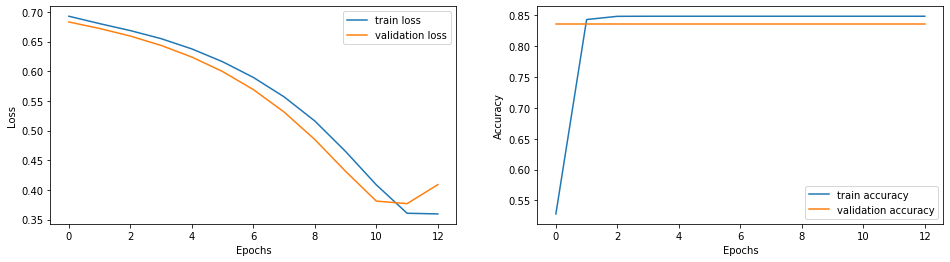

In [21]:
plot_history(history)

**Результаты сравнения моделей при прочих равных условиях**

| Model Type   | Training Time | Epochs to converge | Test Score |
| ----------   | ------------- | ------------------ | ---------- |
|**SimpleRNN** | 2.68 s        | 5                  | **0.886**  |
|**LSTM**      | 5.53 s        | 8                  | **0.886**  |
|**GRU**       | 8.14 s        | 13                 | **0.901**  |